# Vision Transformer: базовая оценка качества

В этом ноутбуке мы инициализируем Vision Transformer и проверим его качество на датасете Tiny-ImageNet без обучения (zero-shot) или с минимальной дообучением.


## Импорты и настройка


In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import numpy as np
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)


## Загрузка датасета Tiny-ImageNet

Используем ту же структуру датасета, что и в первом уроке.


In [24]:
from PIL import Image

class TinyImageNetValDataset(torch.utils.data.Dataset):
    def __init__(self, val_dir, val_annotations_file, class_to_idx, transform=None):
        self.val_dir = val_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        
        self.images = []
        self.labels = []
        
        with open(val_annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    img_name = parts[0]
                    class_name = parts[1]
                    if class_name in class_to_idx:
                        self.images.append(img_name)
                        self.labels.append(class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.val_dir, 'images', self.images[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

data_dir = '../../tiny-imagenet-200'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, 'train'),
    transform=transform
)

val_dataset = TinyImageNetValDataset(
    val_dir=os.path.join(data_dir, 'val'),
    val_annotations_file=os.path.join(data_dir, 'val', 'val_annotations.txt'),
    class_to_idx=train_dataset.class_to_idx,
    transform=transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes[:10]}...")


Train dataset size: 100000
Validation dataset size: 10000
Number of classes: 200
Classes: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']...


## Инициализация Vision Transformer

Создаём модель ViT из библиотеки timm. Загружаем предобученную модель на ImageNet и заменяем голову классификации на нужное количество классов для Tiny-ImageNet.


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

num_classes = len(train_dataset.classes)

model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)
model.eval()

print(f"Model: vit_base_patch16_224")
print(f"Number of classes: {num_classes}")

sample_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(sample_input)
print(f"Output shape: {output.shape}")


Device: cuda
Model: vit_base_patch16_224
Number of classes: 200
Output shape: torch.Size([1, 200])


## Оценка качества на валидации

Вычисляем точность (accuracy) на валидационном датасете. Поскольку модель предобучена на ImageNet, а Tiny-ImageNet является подмножеством ImageNet, ожидаем некоторое базовое качество даже без дообучения.


In [26]:
correct = 0
total = 0
top5_correct = 0

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        num_classes = outputs.shape[1]
        k = min(5, num_classes)
        if k > 1:
            _, top5_pred = torch.topk(outputs, k, dim=1)
            top5_correct += torch.sum(top5_pred == labels.view(-1, 1)).item()
        else:
            top5_correct += (predicted == labels).sum().item()

top1_accuracy = 100 * correct / total
top5_accuracy = 100 * top5_correct / total

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")


Evaluating: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]

Top-1 Accuracy: 0.53%
Top-5 Accuracy: 2.56%


## Патч-эмбеддинг

Изучаем как Vision Transformer разбивает изображение на патчи и создаёт эмбеддинги. Патч-эмбеддинг реализуется через свёртку с kernel_size=P и stride=P, где P - размер патча (для ViT-Base это 16).


In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

patch_embed = model.patch_embed
patch_size = model.patch_embed.patch_size[0]
embed_dim = model.patch_embed.proj.out_channels

print(f"Patch embedding layer: {patch_embed}")
print(f"Patch size: {patch_size}x{patch_size}")
print(f"Embedding dimension: {embed_dim}")

patch_conv = patch_embed.proj
print(f"\nConvolution layer: kernel_size={patch_conv.kernel_size}, stride={patch_conv.stride}")

sample_image, _ = val_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

with torch.no_grad():
    patch_tokens = patch_embed(sample_image)

print(f"\nInput image shape: {sample_image.shape}")
print(f"Patch tokens shape: {patch_tokens.shape}")

num_patches_h = num_patches_w = int(np.sqrt(patch_tokens.shape[1]))
print(f"Number of patches per dimension: {num_patches_h}x{num_patches_w} = {num_patches_h * num_patches_w}")


Patch embedding layer: PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)
Patch size: 16x16
Embedding dimension: 768

Convolution layer: kernel_size=(16, 16), stride=(16, 16)

Input image shape: torch.Size([1, 3, 224, 224])
Patch tokens shape: torch.Size([1, 196, 768])
Number of patches per dimension: 14x14 = 196


### Визуализация сетки патчей

Показываем как изображение разбивается на патчи, визуализируя сетку поверх исходного изображения.


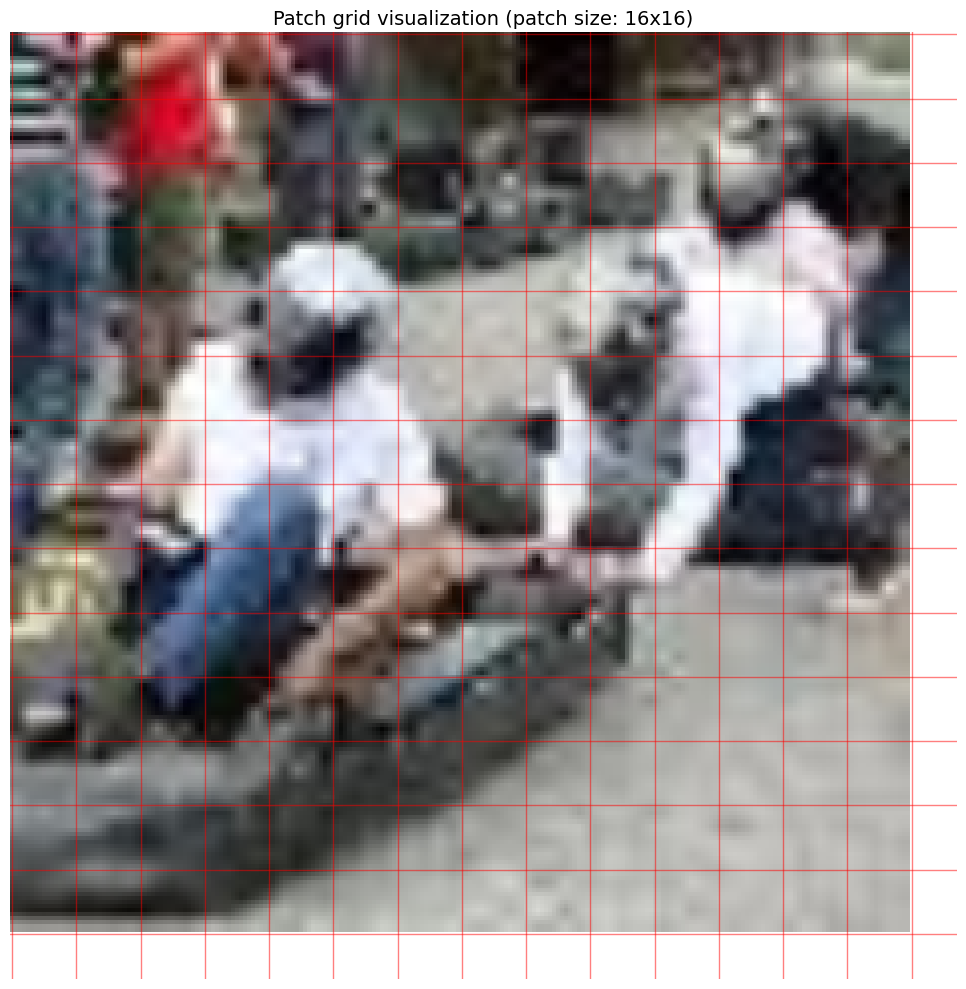

In [28]:
img_np = sample_image[0].cpu().permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img_np)
ax.axis('off')

patch_size = model.patch_embed.patch_size[0]
h, w = img_np.shape[:2]

for i in range(num_patches_h + 1):
    y = i * patch_size
    ax.axhline(y, color='red', linewidth=1, alpha=0.5)

for j in range(num_patches_w + 1):
    x = j * patch_size
    ax.axvline(x, color='red', linewidth=1, alpha=0.5)

ax.set_title(f'Patch grid visualization (patch size: {patch_size}x{patch_size})', fontsize=14)
plt.tight_layout()
plt.show()


### Восстановление изображения из патчей

Извлекаем патчи напрямую из изображения используя ту же логику что и патч-эмбеддинг (Conv с kernel_size=P и stride=P), затем собираем их обратно в изображение для демонстрации блочной реконструкции.


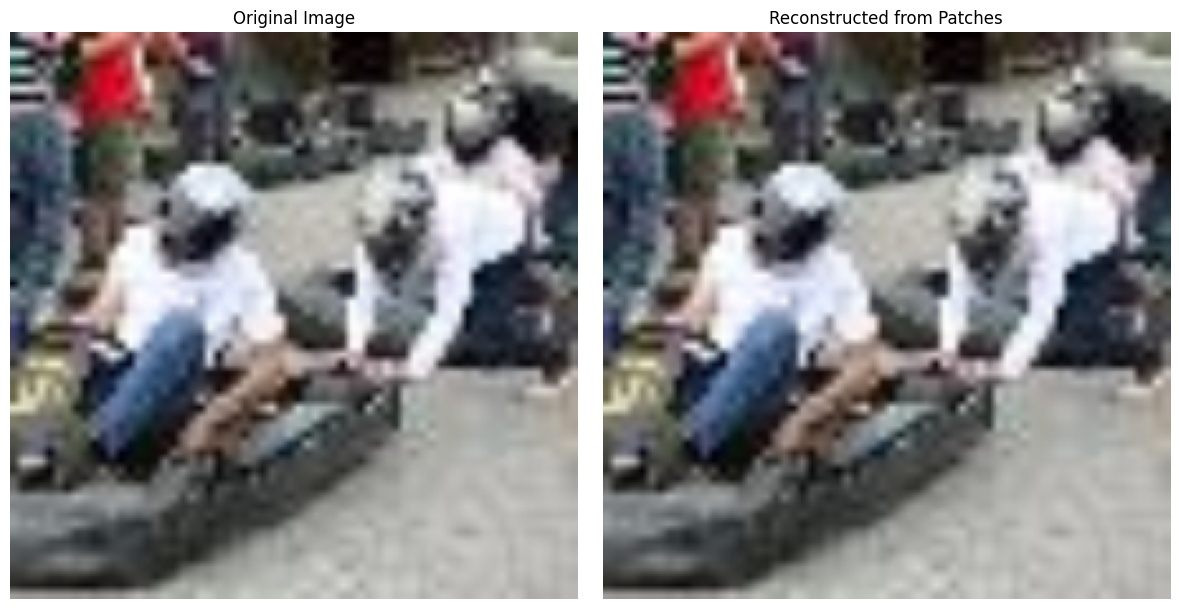

MSE between original and reconstructed: 0.000000


In [29]:
def extract_patches_from_image(image, patch_size=16):
    batch_size, channels, height, width = image.shape
    num_patches_h = height // patch_size
    num_patches_w = width // patch_size
    
    patches = []
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            h_start = i * patch_size
            w_start = j * patch_size
            patch = image[:, :, h_start:h_start+patch_size, w_start:w_start+patch_size]
            patches.append(patch)
    
    return torch.stack(patches, dim=1)

def reconstruct_image_from_patches(patches, patch_size=16, img_size=224):
    batch_size = patches.shape[0]
    num_patches = patches.shape[1]
    channels = patches.shape[2]
    
    num_patches_h = num_patches_w = int(np.sqrt(num_patches))
    
    reconstructed = torch.zeros(batch_size, channels, img_size, img_size)
    for i in range(batch_size):
        for idx, patch in enumerate(patches[i]):
            row = idx // num_patches_w
            col = idx % num_patches_w
            h_start = row * patch_size
            w_start = col * patch_size
            reconstructed[i, :, h_start:h_start+patch_size, w_start:w_start+patch_size] = patch
    
    return reconstructed

patches_extracted = extract_patches_from_image(sample_image, patch_size=patch_size)
reconstructed_img = reconstruct_image_from_patches(patches_extracted, patch_size=patch_size, img_size=224)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

img_np_orig = sample_image[0].cpu().permute(1, 2, 0).numpy()
img_np_recon = reconstructed_img[0].cpu().permute(1, 2, 0).numpy()

axes[0].imshow(np.clip(img_np_orig, 0, 1))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(np.clip(img_np_recon, 0, 1))
axes[1].set_title('Reconstructed from Patches')
axes[1].axis('off')

plt.tight_layout()
plt.show()

mse = torch.mean((sample_image.cpu() - reconstructed_img.cpu()) ** 2).item()
print(f"MSE between original and reconstructed: {mse:.6f}")


Визуализируем отдельные патчи для лучшего понимания структуры.


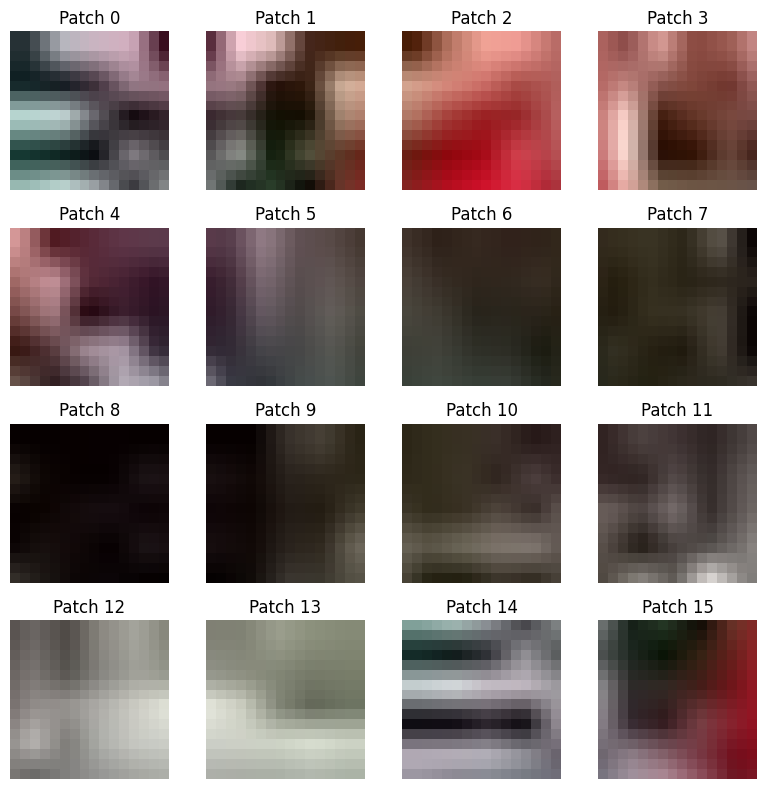

In [30]:
num_patches_to_show = 16
patches_to_show = patches_extracted[0, :num_patches_to_show]

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.ravel()

for i in range(num_patches_to_show):
    patch_np = patches_to_show[i].cpu().permute(1, 2, 0).numpy()
    patch_np = np.clip(patch_np, 0, 1)
    axes[i].imshow(patch_np)
    axes[i].set_title(f'Patch {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Внимание (Attention)

Изучаем механизм внимания в Vision Transformer. Вытаскиваем веса attention из нескольких голов последних слоёв и визуализируем теплокарты, показывающие какие токены обращают внимание друг на друга, особенно внимание к [CLS] токену.


In [31]:
import seaborn as sns

def get_attention_weights(model, x):
    attention_weights = []
    
    def get_attn_from_block(block, x):
        B, N, C = x.shape
        qkv = block.attn.qkv(x).reshape(B, N, 3, block.attn.num_heads, C // block.attn.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * block.attn.scale
        attn = attn.softmax(dim=-1)
        return attn
    
    with torch.no_grad():
        x = model.patch_embed(x)
        if hasattr(model, '_pos_embed'):
            x = model._pos_embed(x)
        if hasattr(model, 'norm_pre'):
            x = model.norm_pre(x)
        
        for block in model.blocks:
            attn = get_attn_from_block(block, x)
            attention_weights.append(attn.detach().cpu())
            x = block(x)
    
    return attention_weights

attention_weights_all = get_attention_weights(model, sample_image)
print(f"Number of layers: {len(attention_weights_all)}")
print(f"Attention weights shape per layer: {attention_weights_all[0].shape}")

num_layers = len(attention_weights_all)
num_heads = attention_weights_all[0].shape[1]
num_tokens = attention_weights_all[0].shape[2]

print(f"Number of attention heads: {num_heads}")
print(f"Number of tokens (including [CLS]): {num_tokens}")


Number of layers: 12
Attention weights shape per layer: torch.Size([1, 12, 197, 197])
Number of attention heads: 12
Number of tokens (including [CLS]): 197


### Визуализация attention из последних слоёв

Показываем теплокарты внимания из нескольких последних слоёв. Каждая теплокарта показывает, на какие токены обращает внимание каждый токен (строка - источник внимания, столбец - цель внимания).


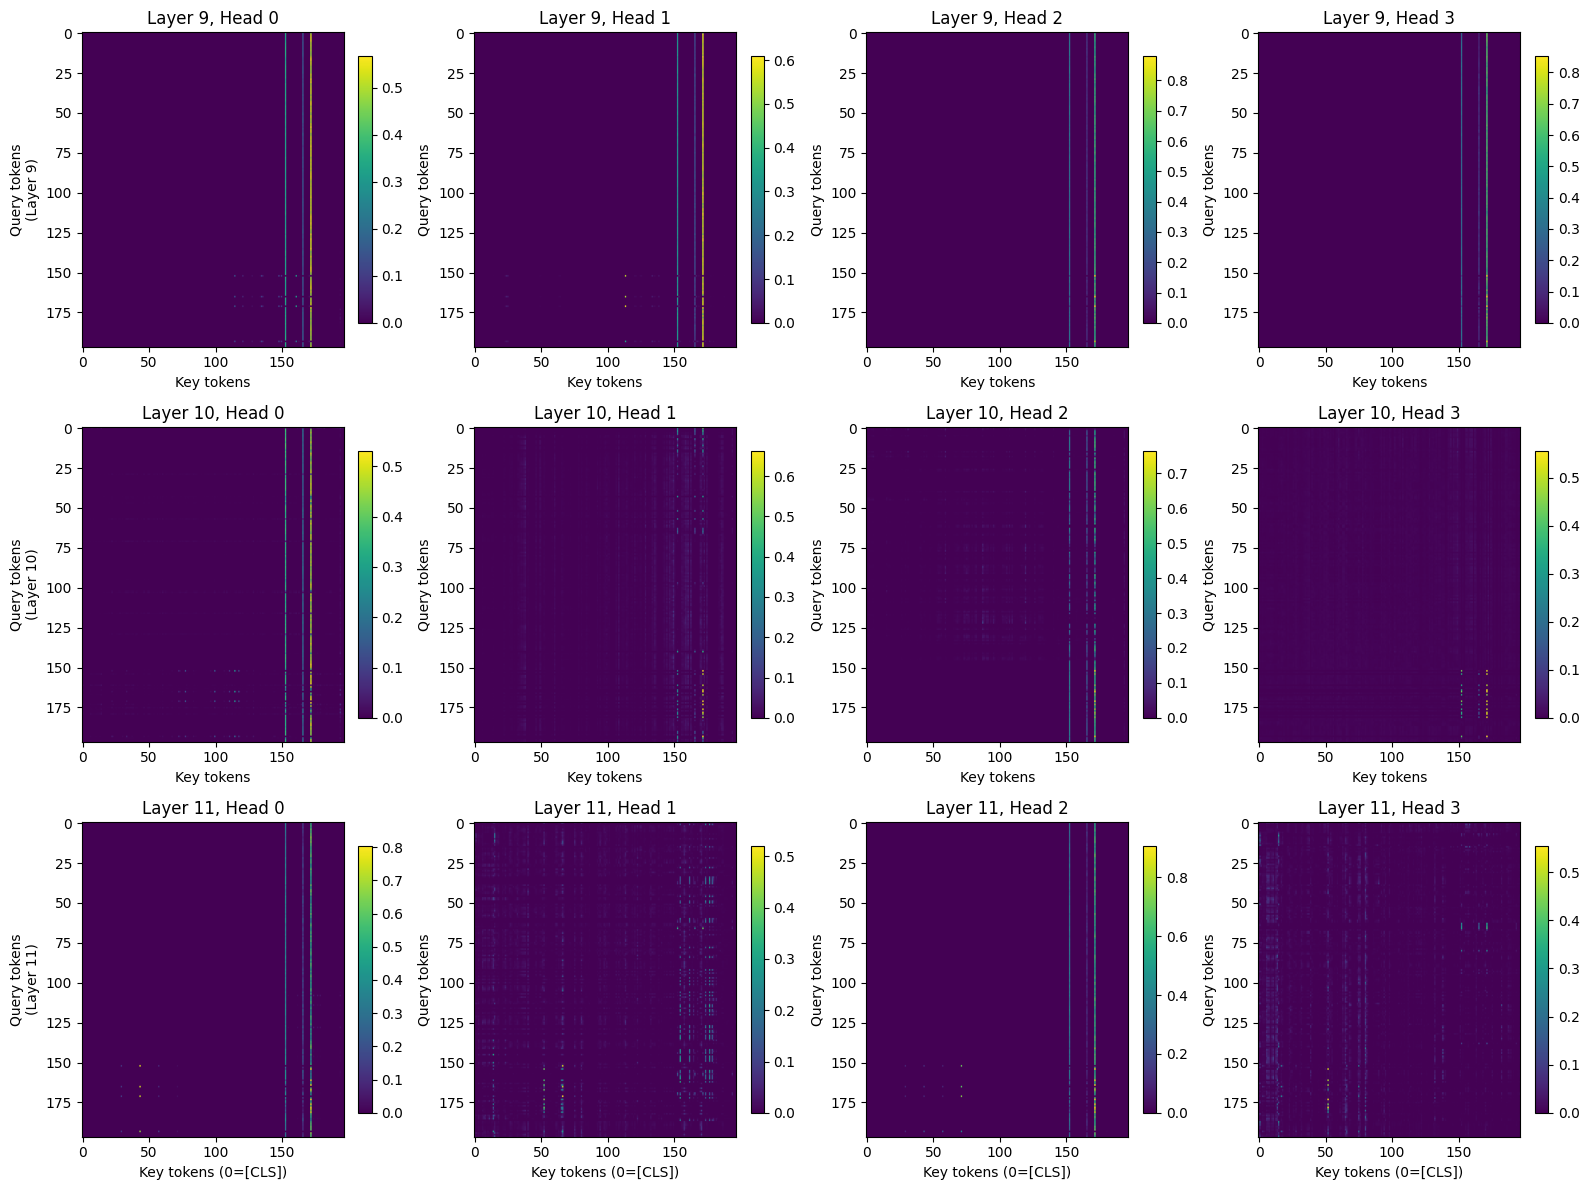

In [32]:
last_layers = [num_layers - 3, num_layers - 2, num_layers - 1]
num_heads_to_show = 4

fig, axes = plt.subplots(len(last_layers), num_heads_to_show, figsize=(16, 12))

for layer_idx, layer_num in enumerate(last_layers):
    attn = attention_weights_all[layer_num]
    
    for head_idx in range(num_heads_to_show):
        ax = axes[layer_idx, head_idx]
        
        attn_map = attn[0, head_idx].numpy()
        
        im = ax.imshow(attn_map, cmap='viridis', aspect='auto')
        ax.set_title(f'Layer {layer_num}, Head {head_idx}')
        ax.set_xlabel('Key tokens')
        ax.set_ylabel('Query tokens')
        
        if layer_idx == len(last_layers) - 1:
            ax.set_xlabel('Key tokens (0=[CLS])')
        if head_idx == 0:
            ax.set_ylabel(f'Query tokens\n(Layer {layer_num})')
        
        plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()


### Внимание к [CLS] токену

Особый интерес представляет внимание к [CLS] токену (первый токен с индексом 0), так как он используется для финальной классификации. Показываем, какие патчи привлекают внимание [CLS] токена в последних слоях.


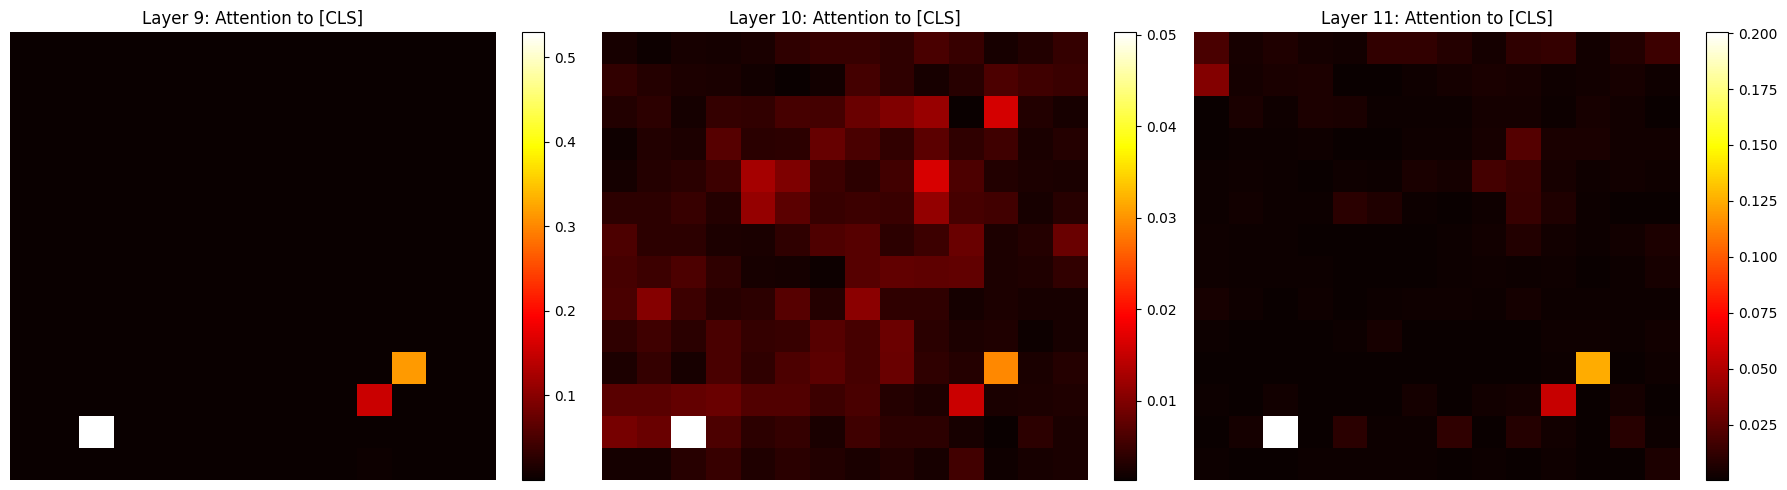

In [33]:
fig, axes = plt.subplots(1, len(last_layers), figsize=(18, 5))

for idx, layer_num in enumerate(last_layers):
    ax = axes[idx]
    
    attn = attention_weights_all[layer_num]
    
    cls_attention = attn[0, :, 0, :].mean(dim=0).numpy()
    
    cls_attention_map = cls_attention[1:].reshape(num_patches_h, num_patches_w)
    
    im = ax.imshow(cls_attention_map, cmap='hot', aspect='auto')
    ax.set_title(f'Layer {layer_num}: Attention to [CLS]')
    ax.axis('off')
    
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()


### Визуализация attention [CLS] на изображении

Наложим карту внимания [CLS] токена на исходное изображение, чтобы увидеть, какие области изображения наиболее важны для классификации.


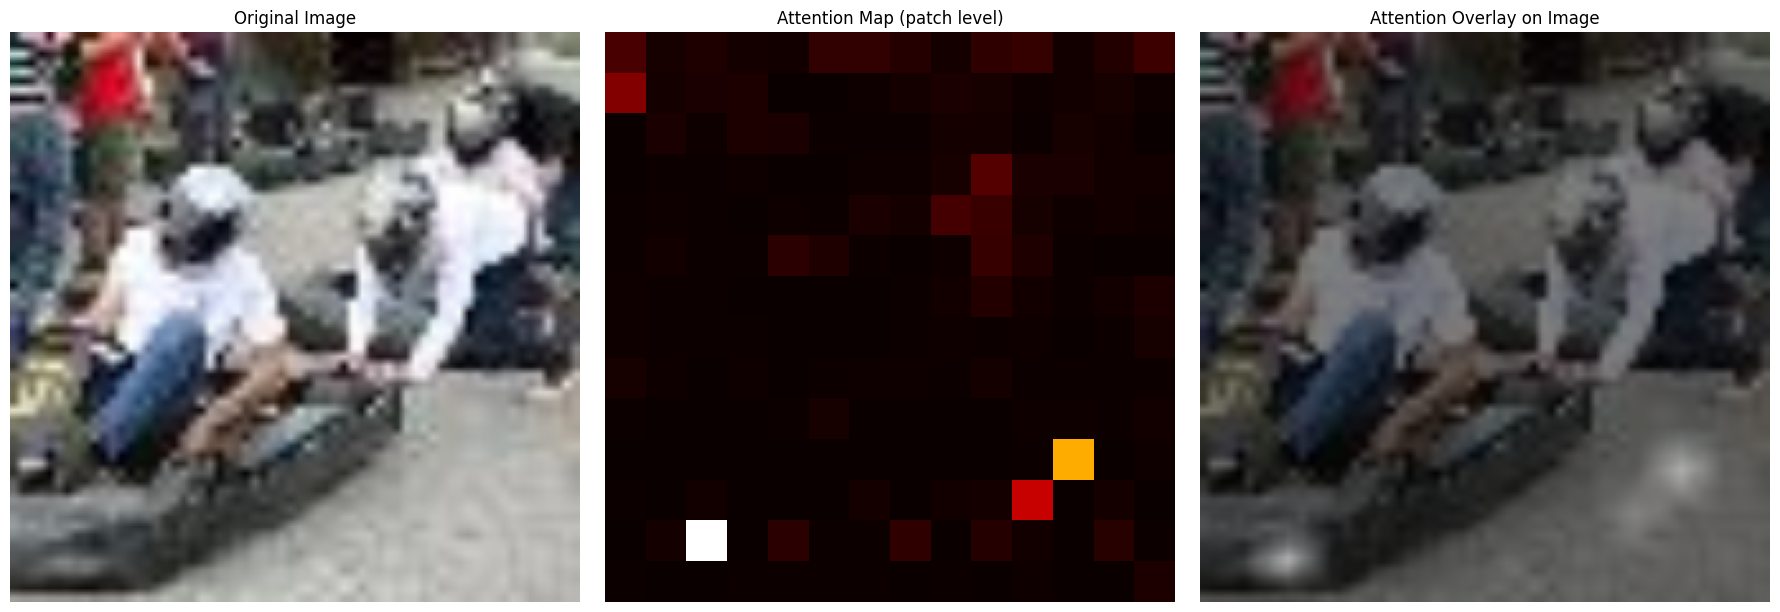

In [34]:
from scipy.ndimage import zoom

last_layer_attn = attention_weights_all[-1]
cls_attention = last_layer_attn[0, :, 0, 1:].mean(dim=0).numpy()
cls_attention_map = cls_attention.reshape(num_patches_h, num_patches_w)

cls_attention_resized = zoom(cls_attention_map, (patch_size, patch_size), order=1)

img_np = sample_image[0].cpu().permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(cls_attention_map, cmap='hot')
axes[1].set_title('Attention Map (patch level)')
axes[1].axis('off')

overlay = img_np.copy()
attention_overlay = np.expand_dims(cls_attention_resized, axis=2)
attention_overlay = np.clip(attention_overlay, 0, 1)
attention_overlay = (attention_overlay - attention_overlay.min()) / (attention_overlay.max() - attention_overlay.min() + 1e-8)

overlay = overlay * 0.5 + attention_overlay * 0.5

axes[2].imshow(overlay)
axes[2].set_title('Attention Overlay on Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### Attention между токенами в последнем слое

Показываем полную матрицу внимания из последнего слоя, усреднённую по всем головам, чтобы увидеть общую картину взаимодействия между токенами.


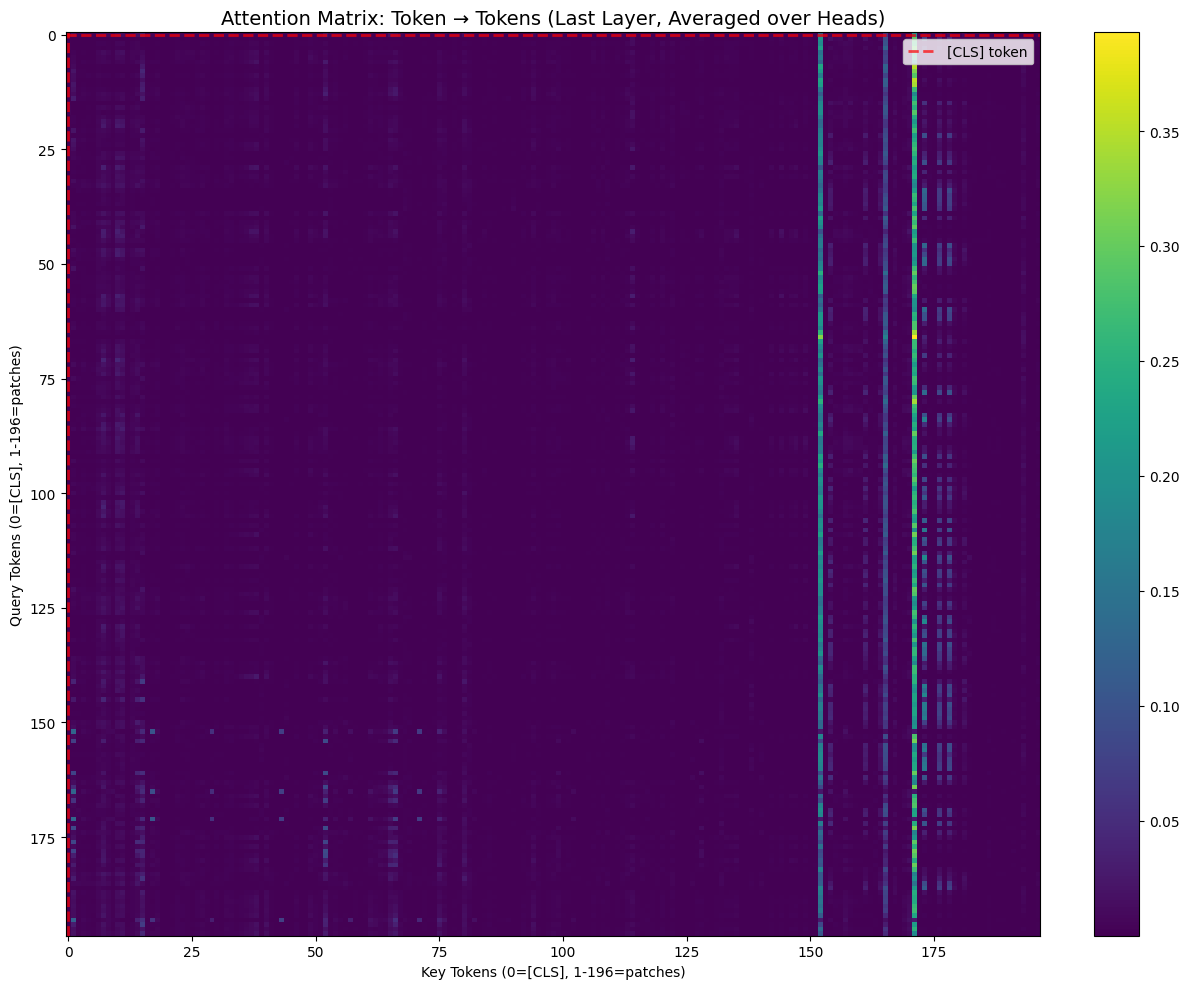

Attention from [CLS] to other tokens (mean): 0.0051
Attention from [CLS] to [CLS]: 0.0008
Attention from [CLS] to patches (mean): 0.0051


In [35]:
last_layer_attn = attention_weights_all[-1]
attn_avg = last_layer_attn[0].mean(dim=0).numpy()

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

im = ax.imshow(attn_avg, cmap='viridis', aspect='auto')
ax.set_title('Attention Matrix: Token → Tokens (Last Layer, Averaged over Heads)', fontsize=14)
ax.set_xlabel('Key Tokens (0=[CLS], 1-196=patches)')
ax.set_ylabel('Query Tokens (0=[CLS], 1-196=patches)')

ax.axhline(y=0, color='red', linewidth=2, linestyle='--', alpha=0.7, label='[CLS] token')
ax.axvline(x=0, color='red', linewidth=2, linestyle='--', alpha=0.7)

plt.colorbar(im, ax=ax, fraction=0.046)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Attention from [CLS] to other tokens (mean): {attn_avg[0, :].mean():.4f}")
print(f"Attention from [CLS] to [CLS]: {attn_avg[0, 0]:.4f}")
print(f"Attention from [CLS] to patches (mean): {attn_avg[0, 1:].mean():.4f}")


## Сравнение [CLS] vs Mean-Pool

Сравниваем два подхода к извлечению признаков для классификации: использование [CLS] токена и усреднение всех патч-токенов (mean-pool). Обучаем отдельные линейные классификаторы для каждого подхода и сравниваем их качество на валидации.


### Подготовка данных и модели

Загружаем train датасет и создаём модель с замороженным бэкабоном для извлечения признаков.


In [36]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of classes: {num_classes}")

feature_model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=0
)

for param in feature_model.parameters():
    param.requires_grad = False

feature_model = feature_model.to(device)
feature_model.eval()

print(f"\nFeature extraction model created")
print(f"Backbone frozen: {all(not p.requires_grad for p in feature_model.parameters())}")


Train dataset size: 100000
Validation dataset size: 10000
Number of classes: 200

Feature extraction model created
Backbone frozen: True


### Извлечение признаков

Извлекаем два вида признаков: [CLS] токен и mean-pool всех патч-токенов.


In [37]:
def extract_features(model, dataloader, device):
    cls_features = []
    mean_pool_features = []
    labels_list = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            labels = labels.to(device)
            
            x = model.patch_embed(images)
            if hasattr(model, '_pos_embed'):
                x = model._pos_embed(x)
            if hasattr(model, 'norm_pre'):
                x = model.norm_pre(x)
            
            for block in model.blocks:
                x = block(x)
            
            cls_feat = x[:, 0]
            mean_pool_feat = x[:, 1:].mean(dim=1)
            
            cls_features.append(cls_feat.cpu())
            mean_pool_features.append(mean_pool_feat.cpu())
            labels_list.append(labels.cpu())
    
    cls_features = torch.cat(cls_features, dim=0)
    mean_pool_features = torch.cat(mean_pool_features, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    return cls_features, mean_pool_features, labels

print("Extracting features from train dataset...")
train_cls_features, train_mean_pool_features, train_labels = extract_features(
    feature_model, train_loader, device
)

print("Extracting features from validation dataset...")
val_cls_features, val_mean_pool_features, val_labels = extract_features(
    feature_model, val_loader, device
)

print(f"\nTrain features shape:")
print(f"  [CLS]: {train_cls_features.shape}")
print(f"  Mean-pool: {train_mean_pool_features.shape}")
print(f"\nValidation features shape:")
print(f"  [CLS]: {val_cls_features.shape}")
print(f"  Mean-pool: {val_mean_pool_features.shape}")


Extracting features from train dataset...


Extracting features: 100%|██████████| 3125/3125 [06:56<00:00,  7.51it/s]


Extracting features from validation dataset...


Extracting features: 100%|██████████| 313/313 [00:42<00:00,  7.38it/s]


Train features shape:
  [CLS]: torch.Size([100000, 768])
  Mean-pool: torch.Size([100000, 768])

Validation features shape:
  [CLS]: torch.Size([10000, 768])
  Mean-pool: torch.Size([10000, 768])


### Обучение линейных классификаторов

Обучаем отдельные линейные классификаторы для [CLS] и mean-pool признаков.


In [38]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

def train_classifier(features, labels, num_classes, device, epochs=10, lr=0.001):
    classifier = LinearClassifier(features.shape[1], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    
    features = features.to(device)
    labels = labels.to(device)
    
    classifier.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    return classifier

print("Training [CLS] classifier...")
cls_classifier = train_classifier(
    train_cls_features, train_labels, num_classes, device, epochs=20, lr=0.001
)

print("Training mean-pool classifier...")
mean_pool_classifier = train_classifier(
    train_mean_pool_features, train_labels, num_classes, device, epochs=20, lr=0.001
)


Training [CLS] classifier...
Training mean-pool classifier...


### Оценка качества на валидации

Вычисляем top-1 и top-5 accuracy для обоих подходов на валидационном датасете.


In [39]:
def evaluate_classifier(classifier, features, labels, device):
    classifier.eval()
    features = features.to(device)
    labels = labels.to(device)
    
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    batch_size = 64
    with torch.no_grad():
        for i in range(0, len(features), batch_size):
            batch_features = features[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            outputs = classifier(batch_features)
            
            _, predicted_top1 = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct_top1 += (predicted_top1 == batch_labels).sum().item()
            
            num_classes = outputs.shape[1]
            k = min(5, num_classes)
            if k > 1:
                _, top5_pred = torch.topk(outputs, k, dim=1)
                correct_top5 += torch.sum(top5_pred == batch_labels.view(-1, 1)).item()
            else:
                correct_top5 += (predicted_top1 == batch_labels).sum().item()
    
    top1_acc = 100 * correct_top1 / total
    top5_acc = 100 * correct_top5 / total
    
    return top1_acc, top5_acc

print("Evaluating [CLS] classifier...")
cls_top1, cls_top5 = evaluate_classifier(cls_classifier, val_cls_features, val_labels, device)

print("Evaluating mean-pool classifier...")
mean_pool_top1, mean_pool_top5 = evaluate_classifier(
    mean_pool_classifier, val_mean_pool_features, val_labels, device
)

print("\n" + "="*60)
print("Results:")
print("="*60)
print(f"{'Method':<20} {'Top-1 Accuracy':<20} {'Top-5 Accuracy':<20}")
print("-"*60)
print(f"{'[CLS]':<20} {cls_top1:.2f}%{'':<15} {cls_top5:.2f}%")
print(f"{'Mean-Pool':<20} {mean_pool_top1:.2f}%{'':<15} {mean_pool_top5:.2f}%")
print("="*60)


Evaluating [CLS] classifier...
Evaluating mean-pool classifier...

Results:
Method               Top-1 Accuracy       Top-5 Accuracy      
------------------------------------------------------------
[CLS]                85.36%                95.33%
Mean-Pool            84.89%                94.99%


### Визуализация сравнения

Визуализируем результаты сравнения двух подходов.


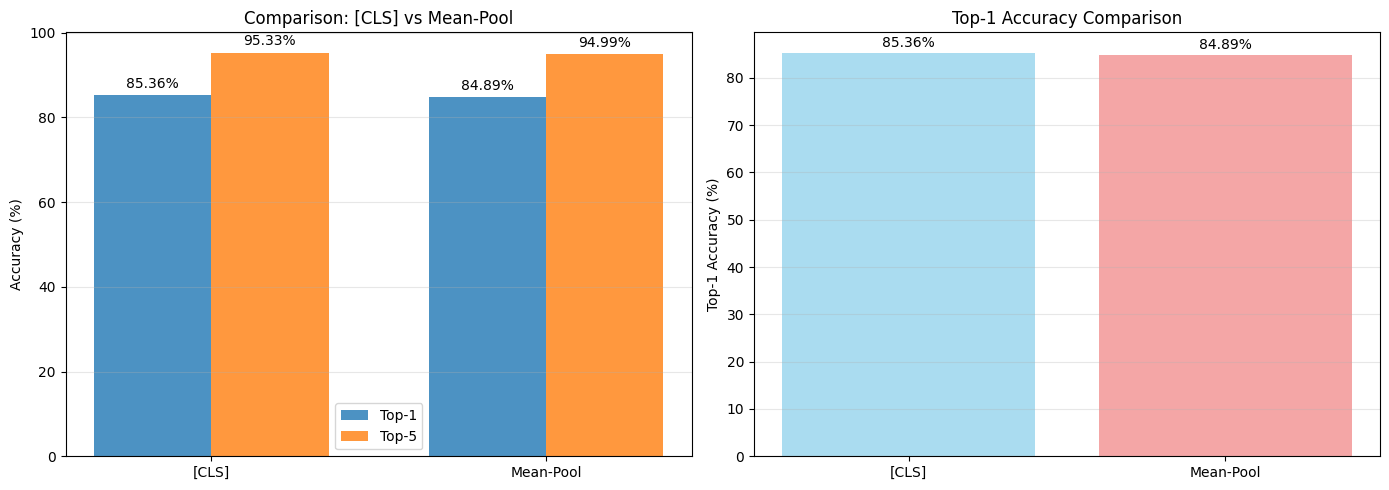

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['[CLS]', 'Mean-Pool']
top1_scores = [cls_top1, mean_pool_top1]
top5_scores = [cls_top5, mean_pool_top5]

x = np.arange(len(methods))
width = 0.35

axes[0].bar(x - width/2, top1_scores, width, label='Top-1', alpha=0.8)
axes[0].bar(x + width/2, top5_scores, width, label='Top-5', alpha=0.8)
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Comparison: [CLS] vs Mean-Pool')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for i, (t1, t5) in enumerate(zip(top1_scores, top5_scores)):
    axes[0].text(i - width/2, t1 + 1, f'{t1:.2f}%', ha='center', va='bottom')
    axes[0].text(i + width/2, t5 + 1, f'{t5:.2f}%', ha='center', va='bottom')

axes[1].bar(['[CLS]', 'Mean-Pool'], top1_scores, alpha=0.7, color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('Top-1 Accuracy (%)')
axes[1].set_title('Top-1 Accuracy Comparison')
axes[1].grid(axis='y', alpha=0.3)

for i, score in enumerate(top1_scores):
    axes[1].text(i, score + 0.5, f'{score:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
